<a href="https://colab.research.google.com/github/rita68034/ML_Project_Twitter_data-MERGED-/blob/main/ML_Project_Twitter_data(MERGED).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# SETUP

!pip install squarify
!pip install tensorflow==2.13.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 65.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 71.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 32.2 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.12.2
    Uninstalling typing_extensions-4.12.2:
      Successfully uninstalled typing_extensions-4.12.2
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: gast
    Found existing installation: gast 0.6.0
    Uninstalling gast-0.6.0:
      

In [ ]:
## Importing the necessary libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import requests
from PIL import Image
from collections import Counter
import squarify
from tqdm import tqdm

import string
import re
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud ,STOPWORDS
import spacy
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

import shutil
import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from keras.models import Sequential
from keras.layers import LSTM, GRU,SimpleRNN
from keras.layers import Dense, Activation, Dropout
from keras.layers import Embedding
from keras.layers import BatchNormalization
from keras.utils import to_categorical
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping

# Load the spaCy English model
nlp = spacy.load("en_core_web_sm")
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Tensorflow version 2.13.0
REPLICAS:  1


In [ ]:
# Helper functions

def add_spines(colour = '#425169', linewidth = 2):
    ax = plt.gca()
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines[['bottom', 'left', 'top', 'right']].set_color(colour)
    ax.spines[['bottom', 'left', 'top', 'right']].set_linewidth(linewidth)

def roc_auc(predictions,target):
    fpr, tpr, thresholds = metrics.roc_curve(target, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    return roc_auc

### Basic preprocessing and sample tweets <a class="anchor"  id="a2"></a>

In [ ]:
df = pd.read_csv("/content/twitter_merged.csv")
df

,index,id,Text,Annotation,oh_label
0,5.74948705591165E+017,5.74948705591165E+017,@halalflaws @biebervalue @greenlinerzjm I read...,none,0.0
1,5.71917888690393E+017,5.71917888690393E+017,@ShreyaBafna3 Now you idiots claim that people...,none,0.0
2,3.90255841338601E+017,3.90255841338601E+017,"RT @Mooseoftorment Call me sexist, but when I ...",sexism,1.0
3,5.68208850655916E+017,5.68208850655916E+017,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",racism,1.0
4,5.75596338802373E+017,5.75596338802373E+017,#mkr No No No No No No,none,0.0
...,...,...,...,...,...
45198,5.76422824501379E+017,5.76422824501379E+017,@RaikonL @finaleve @mja333 WHY DO YOU HATE FRE...,none,0.0
45199,4.64045547473498E+017,4.64045547473498E+017,It is unconscionable that our regulatory bodie...,none,0.0
45200,5.54705698508919E+017,5.54705698508919E+017,@Dartanveerahmad @Janx53 @geehall1 We want ISI...,none,0.0
45201,5.7560079584598E+017,5.7560079584598E+017,#mkr Unbelievable how low Kat &amp; Andre wil...,none,0.0


In [ ]:
df.drop_duplicates(inplace=True)
df = df.drop(['id', 'index'], axis=1)
df.rename(columns={'oh_label': 'Label'}, inplace=True)
df.dropna(subset='Label',inplace=True)
# analysis of mentions and tweets

# here we create a function to count the number of hashtags and mentions and then create two columns to store this data
def count_symbols(text):
    hashtag_count = len(re.findall(r'#', text))
    mention_count = len(re.findall(r'@', text))
    return hashtag_count, mention_count

# Apply the function to each row in the 'text' column
df[['num_hashtags', 'num_mentions']] = df['Text'].apply(lambda x: pd.Series(count_symbols(x)))

print('\nDataset shape: ', df.shape)
df.head()


Dataset shape:  (30319, 5)


,Text,Annotation,Label,num_hashtags,num_mentions
0,@halalflaws @biebervalue @greenlinerzjm I read...,none,0.0,0,3
1,@ShreyaBafna3 Now you idiots claim that people...,none,0.0,0,1
2,"RT @Mooseoftorment Call me sexist, but when I ...",sexism,1.0,0,1
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",racism,1.0,0,1
4,#mkr No No No No No No,none,0.0,1,0


In [ ]:
print('_Sample tweets_')
simple_tweet = df[df['Label'] == 0]['Text'].iloc[1]
print('\nSimple tweet: ', simple_tweet)
sexist_tweet = df[df['Annotation'] == 'sexism']['Text'].iloc[0]
print('\n\nSexist tweet: ', sexist_tweet)
racist_tweet = df[df['Annotation'] == 'racism']['Text'].iloc[0]
print('\n\nRacist tweet: ', racist_tweet)

_Sample tweets_

Simple tweet:  @ShreyaBafna3 Now you idiots claim that people who tried to stop him from becoming a terrorist made him a terrorist. Islamically brain dead.


Sexist tweet:  RT @Mooseoftorment Call me sexist, but when I go to an auto place, I'd rather talk to a guy


Racist tweet:  @g0ssipsquirrelx Wrong, ISIS follows the example of Mohammed and the Quran exactly.


# Exploratory Data Analysis <a class="anchor"  id="chapter1"></a>

>We analyse different aspects of the twitter dataset here. We start with simple tasks like understanding the label and Annotation distribution, and slowly progress toward extracting and analysing #hashtags, @mentions and finally generate wordclouds of high frequency words according to annotations.

In [ ]:
# Basic analysis of labels and annotations

print('Label distribution')
print(df.Label.value_counts())
print('Annotation distribution')
print(df.Annotation.value_counts())
print('Grouping of Annotation with label')
print(df.groupby('Annotation')['Label'].sum())

Label distribution
Label
0.0    23002
1.0     7317
Name: count, dtype: int64
Annotation distribution
Annotation
none      23002
racism     3940
sexism     3377
Name: count, dtype: int64
Grouping of Annotation with label
Annotation
none         0.0
racism    3940.0
sexism    3377.0
Name: Label, dtype: float64


As you can see the text with annotations of anything other than none are all classified as toxic. Hence, it would be a dead giveaway to include it in our dataset. We may try to classify the text with the annotations later
___

#### Highlighting columns in your seaborn plots<br>
This is just a fun way in which you can highlight certain bars in your barplot. We create a specific function that returns a palette of length equal to the unique categories in the column you're plotting and specifically highlights the indexes passed to it.

In [ ]:
def bully_palette(df,column, positions_to_change: list):
    """
    A function to create grey red palettes according to the inputs
    You just need to pass in the dataframe and the index of labels to be highlighted in red
    """
    palette = ['#96898b']*df[column].nunique()
    new_values = ['#cc253b']*len(positions_to_change)
    for position, new_value in zip(positions_to_change, new_values):
        palette[position] = new_value
    return sns.color_palette(palette)

# example
# bully_palette(df,'Label', [0, 1])

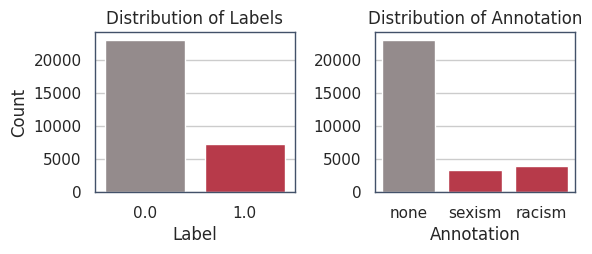

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(6, 2))

plt.subplot(1, 2, 1)
# using the bully_pallete function to create a custom pallete
sns.countplot(x='Label', data=df, palette = bully_palette(df, 'Label', [1]))
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels')
# adding spines using the helper function we declared earlier
add_spines(linewidth=1)

plt.subplot(1, 2, 2)
sns.countplot(x='Annotation', data=df, palette = bully_palette(df,'Annotation', [1, 2]))
plt.xlabel('Annotation')
plt.ylabel('')
plt.title('Distribution of Annotation')
add_spines(linewidth=1)

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.4, hspace=0.3)
plt.show()

This is how our highlighted plots turned out. Do play around with these... highlight with your own colours... add functionalities etc.<br><br>
We can see that the lable `1` has further been divided into the categories `sexism` and `racism`. Sexism is more prevelant than racism. Racism is looked upon more harshly by the public or twitter might be efficient at removing racist tweets from their site.

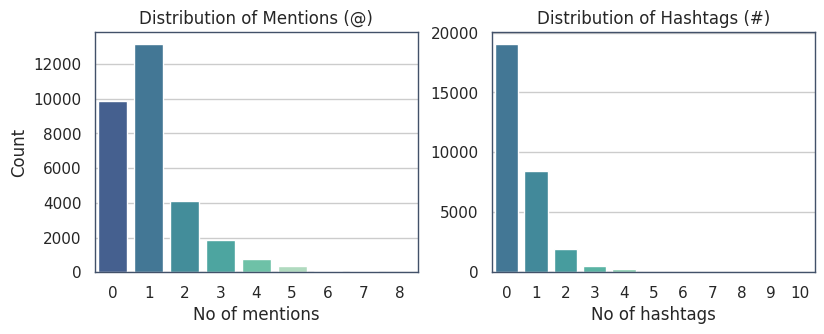

In [ ]:
plt.figure(figsize=(9, 3))

plt.subplot(1, 2, 1)
sns.countplot(x='num_mentions', data=df, palette =  sns.color_palette("mako", n_colors=9)[3:])
plt.xlabel('No of mentions')
plt.ylabel('Count')
plt.title('Distribution of Mentions (@)')
add_spines(linewidth=1)

plt.subplot(1, 2, 2)
sns.countplot(x='num_hashtags', data=df, palette = sns.color_palette("mako", n_colors=11)[5:])
plt.xlabel('No of hashtags')
plt.ylabel('')
plt.title('Distribution of Hashtags (#)')
add_spines(linewidth=1)

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.23, hspace=0.3)
plt.show()

<Figure size 600x300 with 0 Axes>

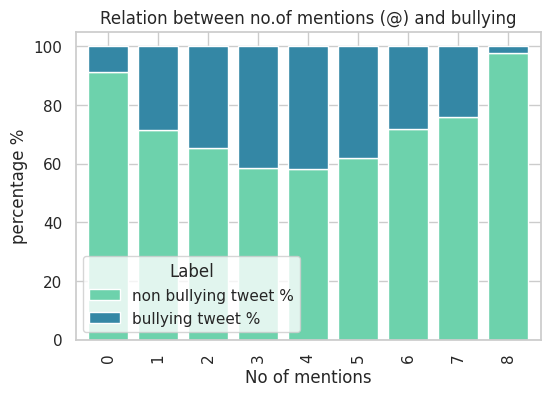

In [ ]:
plt.figure(figsize=(6, 3))
mention_label_cross = pd.crosstab(df['num_mentions'], df['Label'])
mention_label_cross['sum'] = mention_label_cross[0.0] + mention_label_cross[1.0]
mention_label_cross['non bullying tweet %'] = mention_label_cross[0.0]/mention_label_cross['sum']*100
mention_label_cross['bullying tweet %'] = mention_label_cross[1.0]/mention_label_cross['sum']*100
mention_label_cross = mention_label_cross.drop([0.0, 1.0, 'sum'], axis=1)

mention_label_cross.plot(kind='bar', stacked=True, figsize=(6, 4), color=['#6dd2ac', '#3487a5'], width=0.8)
plt.xlabel('No of mentions')
plt.ylabel('percentage %')
plt.title('Relation between no.of mentions (@) and bullying')
plt.show()

> Here you can see that as the mentions increase to 3 to 4, the percentage of bullying tweets increases compared to the normal ones. But the trend once again reverses as the mentions increase upto 8. No clear pattern was seen between number of hashtags and percentage of bullying tweets

### Sentiment analysis
Here I planned on checking whether the sentiment of the tweets directly correlate with bullying. ie. more  negativity a tweet contains, higher the probability of bullying. Turns out it wasn't as straightforward as that. The dataset contains a lot of negative tweets... which is a good thing since our models should be able to understand the difference between a `negative` tweet and a `bullying` tweet. It shouldn't flag every other negative tweet as bullying.

In [ ]:
## Using the nltk library to analyze sentiment of each text so that we can correlate it with bullying
# Initialize the VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Function to get sentiment of a text
def get_sentiment(text):
    if isinstance(text, float):
        return 'neutral'
    else:
        compound_score = sia.polarity_scores(text)['compound']
        return 'positive' if compound_score >= 0 else 'negative'


df['Sentiment_Label'] = df['Text'].apply(get_sentiment)
df.head()

,Text,Annotation,Label,num_hashtags,num_mentions,Sentiment_Label
0,@halalflaws @biebervalue @greenlinerzjm I read...,none,0.0,0,3,negative
1,@ShreyaBafna3 Now you idiots claim that people...,none,0.0,0,1,negative
2,"RT @Mooseoftorment Call me sexist, but when I ...",sexism,1.0,0,1,positive
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",racism,1.0,0,1,negative
4,#mkr No No No No No No,none,0.0,1,0,negative


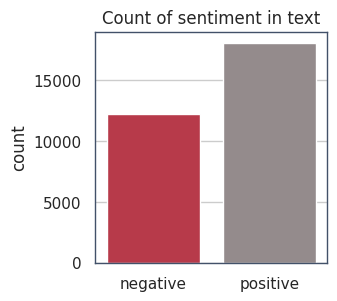

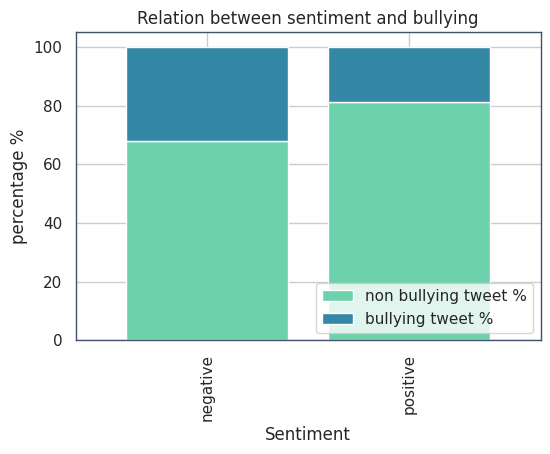

In [ ]:
plt.figure(figsize=(3, 3))
df['Sentiment_Label'].value_counts()
sns.countplot(x='Sentiment_Label', data=df, palette = bully_palette(df, 'Sentiment_Label', [0]))
plt.title('Count of sentiment in text')
plt.xlabel('')
add_spines(linewidth=1)

sent_label_cross = pd.crosstab(df['Sentiment_Label'], df['Label'])
sent_label_cross['sum'] = sent_label_cross[0.0] + sent_label_cross[1.0]
sent_label_cross['non bullying tweet %'] = sent_label_cross[0.0]/sent_label_cross['sum']*100
sent_label_cross['bullying tweet %'] = sent_label_cross[1.0]/sent_label_cross['sum']*100
sent_label_cross = sent_label_cross.drop([0.0, 1.0, 'sum'], axis=1)

ax = sent_label_cross.plot(kind='bar', stacked=True, figsize=(6, 4), color=['#6dd2ac', '#3487a5'], width=0.8)
plt.xlabel('Sentiment')
plt.ylabel('percentage %')
plt.title('Relation between sentiment and bullying')
ax.legend(loc='lower right')
add_spines(linewidth=1)

plt.show()

### Analysis of common hashtags and mentions

The tweets contain a bunch of hashtags and mentions.
- The tweets seems to be majorly sourced from particular feeds or are retweets to particular user.
- A majority of the tweets feature the TV show `My kitchen rules`.(`#mkr`)

In [ ]:
## Extraction of the top ten mentions and hashtags in the dataset

# Function to extract hashtags from a text
def extract_hashtags(text):
    return re.findall(r'#\w+', text)

df['Hashtags'] = df['Text'].apply(extract_hashtags)

# Function to extract hashtags from a text
def extract_mentions(text):
    return re.findall(r'@\w+', text)

df['Mentions'] = df['Text'].apply(extract_mentions)

def create_counter_df(df):
    # Flatten the list of hashtags and count their occurrences
    all_counts = [tag for counts_list in df for tag in counts_list]
    label_counts = Counter(all_counts)

    # Create a DataFrame from the Counter dictionary
    counts_df = pd.DataFrame(list(label_counts.items()), columns=['Label', 'Count'])
    counts_df = counts_df.sort_values(by='Count', ascending=False)
    return counts_df

mentions_df = create_counter_df(df['Mentions'])
top_10_mentions = mentions_df.head(10)
sexist_mentions = create_counter_df(df[df.Annotation=='sexism']["Mentions"])
top_10_sexist_mentions = sexist_mentions.head(10)
racist_mentions = create_counter_df(df[df.Annotation=='racism']["Mentions"])
top_10_racist_mentions = racist_mentions.head(10)

hashtags_df = create_counter_df(df['Hashtags'])
top_10_hashtags = hashtags_df.head(10)
sexist_hashtags = create_counter_df(df[df.Annotation=='sexism']["Hashtags"])
top_10_sexist_hashtags = sexist_hashtags.head(10)
racist_hashtags = create_counter_df(df[df.Annotation=='racism']["Hashtags"])
top_10_racist_hashtags = racist_hashtags.head(10)

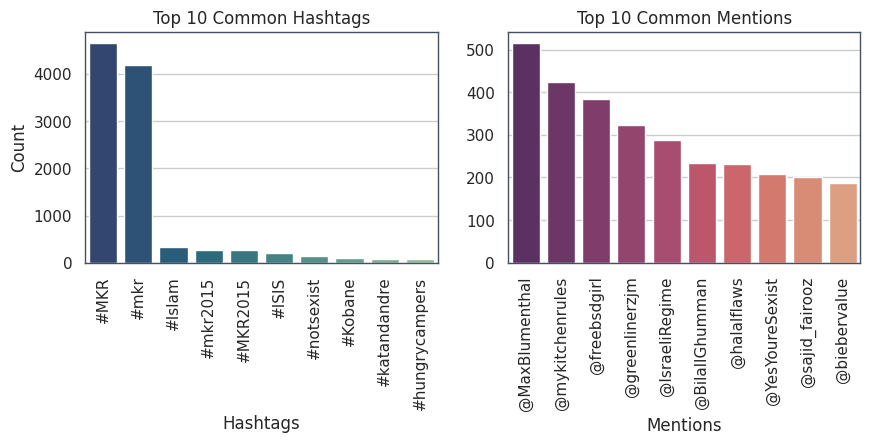

In [ ]:
plt.figure(figsize=(10, 3))

plt.subplot(121)
sns.barplot(x='Label', y='Count', data=top_10_hashtags, palette='crest_r')
plt.title('Top 10 Common Hashtags')
plt.xlabel('Hashtags')
plt.ylabel('Count')
plt.xticks(rotation=90)
add_spines(linewidth=1)

plt.subplot(122)
sns.barplot(x='Label', y='Count', data=top_10_mentions, palette='flare_r')
plt.title('Top 10 Common Mentions')
plt.xlabel('Mentions')
plt.ylabel('')
plt.xticks(rotation=90)
add_spines(linewidth=1)

`#MKR` (@mykitchenrules) is the most popular hashtag in the dataset whereas `@MaxBlumenthal` is the most popular mention.



I did some digging around `@MaxBlumenthal` and found this:

#### Who he is:
- American author and blogger: Born in 1977, Blumenthal has written for publications like The Nation, The New York Times, and The Daily Beast. He currently edits The Grayzone website.
- Investigative journalist: Blumenthal's work focuses on politics, media, and human rights, often with a critical view of US foreign policy and the Israeli-Palestinian conflict.
- Author: He's written several books, including "Republican Gomorrah" and "Goliath: Life and Loathing in Greater Israel," which won awards and ignited debate.

#### Controversies:
- The Grayzone: Some see The Grayzone as promoting conspiracy theories and Russian propaganda, particularly regarding the Syrian Civil War. Blumenthal maintains editorial independence and focuses on investigative journalism.
- Methodology: Critics question Blumenthal's use of anonymous sources and selective evidence, while supporters defend his investigative techniques and access to information denied to mainstream media.

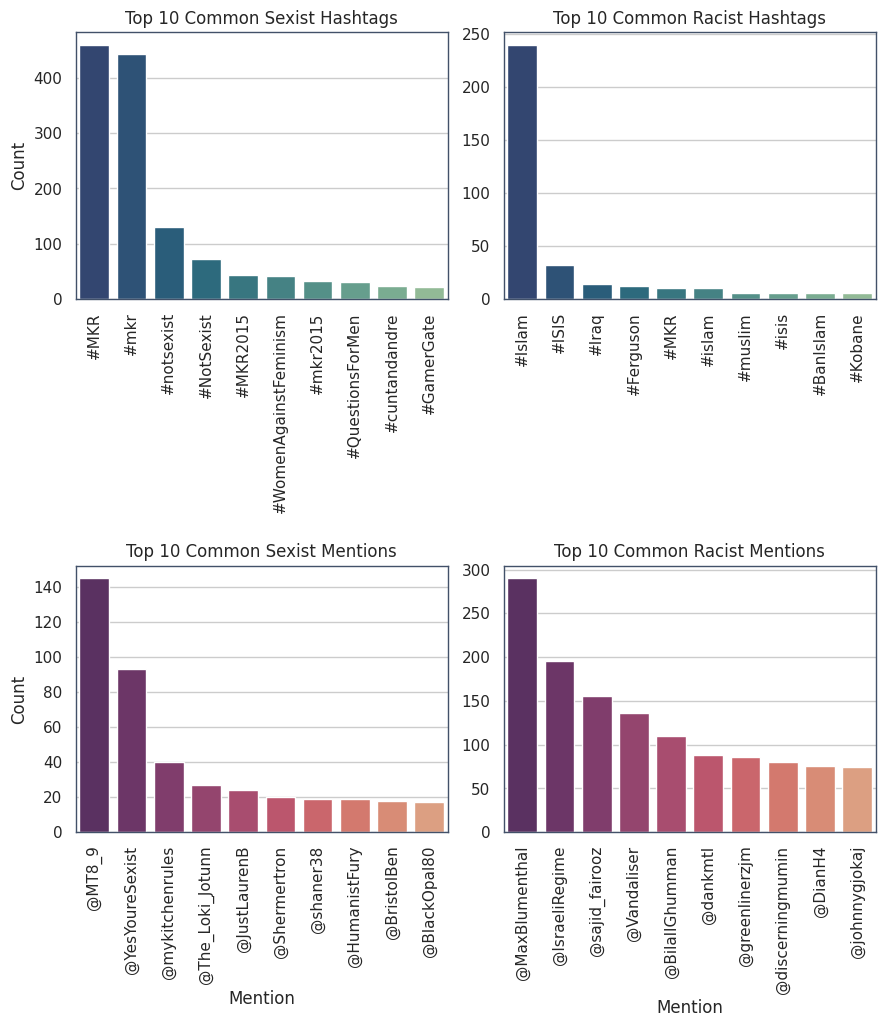

In [ ]:
plt.figure(figsize=(10, 10))

plt.subplot(221)
sns.barplot(x='Label', y='Count', data=top_10_sexist_hashtags, palette='crest_r')
plt.title('Top 10 Common Sexist Hashtags')
plt.xlabel('')
plt.ylabel('Count')
plt.xticks(rotation=90)
add_spines(linewidth=1)

plt.subplot(222)
sns.barplot(x='Label', y='Count', data=top_10_racist_hashtags, palette='crest_r')
plt.title('Top 10 Common Racist Hashtags')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=90)
add_spines(linewidth=1)

plt.subplot(223)
sns.barplot(x='Label', y='Count', data=top_10_sexist_mentions, palette='flare_r')
plt.title('Top 10 Common Sexist Mentions')
plt.xlabel('Mention')
plt.ylabel('Count')
plt.xticks(rotation=90)
add_spines(linewidth=1)

plt.subplot(224)
sns.barplot(x='Label', y='Count', data=top_10_racist_mentions, palette='flare_r')
plt.title('Top 10 Common Racist Mentions')
plt.xlabel('Mention')
plt.ylabel('')
plt.xticks(rotation=90)
add_spines(linewidth=1)

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.15, hspace=1)
plt.show()

#### Key takeaways from the most common @ and #s

- For some reason `#MKR` and `#mkr` (my kitchen rules) feature on the top of the sexist hashtags. Maybe because its a cooking show.It might be due to the fact that #MKR is the most common hashtag on the dataset. <br>
- You can see religiously motived terrorist groups like `#isis` feature on the most common racist hashtags with `#islam` <br>
- `@YesYoureSexist` sounds like a provocative username. No wonder it has the second most sexist mentions
- `@MaxBlumenthal` a controversial American author and blogger features on the top of Racist mentions

### Preprocessing the text

In [ ]:
def clean_tweet(text):
    # Remove URLs
    tweet = re.sub(r'http\S+', '', text)
    # Remove mentions and hashtags
    tweet = re.sub(r'@[A-Za-z0-9_]+|#[A-Za-z0-9_]+', '', tweet)
    # Remove special characters, numbers, and punctuation
    tweet = re.sub(r'[^A-Za-z\s]', '', tweet)
    # Remove 'RT' (Retweet) indicator
    tweet = re.sub(r'^RT', '', tweet)
    # Convert into lowercase
    text = tweet.lower()
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    # Join tokens back into text
    preprocessed_text = ' '.join(lemmatized_tokens)
    return preprocessed_text

In [ ]:
df['Text'] = df['Text'].apply(clean_tweet)
df.head()

,Text,Annotation,Label,num_hashtags,num_mentions,Sentiment_Label,Hashtags,Mentions
0,read contextno change meaning history islamic ...,none,0.0,0,3,negative,[],"[@halalflaws, @biebervalue, @greenlinerzjm]"
1,idiot claim people tried stop becoming terrori...,none,0.0,0,1,negative,[],[@ShreyaBafna3]
2,call sexist go auto place id rather talk guy,sexism,1.0,0,1,positive,[],[@Mooseoftorment]
3,wrong isi follows example mohammed quran exactly,racism,1.0,0,1,negative,[],[@g0ssipsquirrelx]
4,,none,0.0,1,0,negative,[#mkr],[]


In [ ]:
print('_Sample clean tweets_')
simple_tweet = df[df['Label'] == 0]['Text'].iloc[1]
print('\n\nSimple tweet: ', simple_tweet)
sexist_tweet = df[df['Annotation'] == 'sexism']['Text'].iloc[0]
print('\n\nSexist tweet: ', sexist_tweet)
racist_tweet = df[df['Annotation'] == 'racism']['Text'].iloc[0]
print('\n\nRacist tweet: ', racist_tweet)

_Sample clean tweets_


Simple tweet:  idiot claim people tried stop becoming terrorist made terrorist islamically brain dead


Sexist tweet:  call sexist go auto place id rather talk guy


Racist tweet:  wrong isi follows example mohammed quran exactly


## Wordclouds for toxic text <a class="anchor"  id="section_1_3"></a>

Using a popular method of plotting wordclouds in the shapes of masks created out of png images.

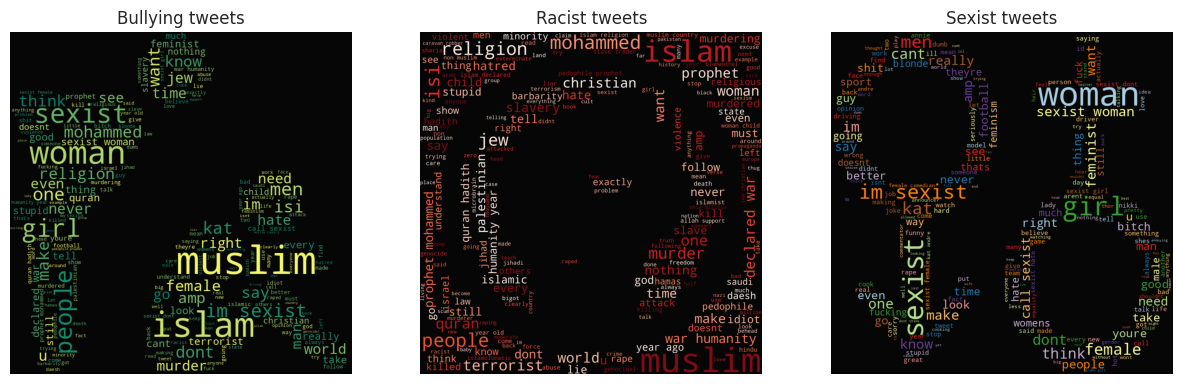

In [ ]:
stopword=set(STOPWORDS)
plt.figure(figsize=(15,40))

## Common words in all bullying tweets
plt.subplot(131)
# 1. Get text
bully_text = df[df.Label==1.0]["Text"].values
Text = ''
for text in bully_text:
    Text += text

# 2. Load png image from url and create mask
image_url = 'https://raw.githubusercontent.com/harshjadhav890/cyberbullying_detection/main/bullying-computer-icons-harassment-clip-art-bully.jpg'
response = requests.get(image_url, stream=True)
response.raise_for_status()
mask = np.array(Image.open(response.raw))

# 3. Plot wordcloud
wc = WordCloud(background_color = 'black', mask = mask, contour_width = 2,
     contour_color = 'black', colormap = 'BuPu_r', width = 800, height = 800, stopwords = stopword).generate(Text)
plt.axis("off")
plt.title('Bullying tweets')
plt.imshow(wc.recolor(colormap= 'summer' , random_state=244), alpha=0.98)


## Common words in all racist tweets
# Repeat for other plots
plt.subplot(132)
bully_text = df[df.Annotation=='racism']["Text"].values
Text = ''
for text in bully_text:
    Text += text

image_url = 'https://clipart-library.com/img1/1475559.png'
response = requests.get(image_url, stream=True)
response.raise_for_status()
mask = np.array(Image.open(response.raw))

wc = WordCloud(background_color = 'black', mask = mask, contour_width = 2,
     contour_color = 'black', colormap = 'BuPu_r', width = 800, height = 800, stopwords = stopword).generate(Text)
plt.title('Racist tweets')
plt.axis("off")
plt.imshow(wc.recolor(colormap= 'Reds' , random_state=244), alpha=0.98)


## Common words in all sexist tweets
plt.subplot(133)
bully_text = df[df.Annotation=='sexism']["Text"].values
Text = ''
for text in bully_text:
    Text += text

image_url = 'https://raw.githubusercontent.com/harshjadhav890/cyberbullying_detection/main/woman-gender-symbol-male-female-text-line-circle-number-png-clipart.jpg'
response.raise_for_status()
response = requests.get(image_url, stream=True)
mask = np.array(Image.open(response.raw))

wc = WordCloud(background_color = 'black', mask = mask, contour_width = 2,
     contour_color = 'black', colormap = 'BuPu_r', width = 800, height = 800, stopwords = stopword).generate(Text)
plt.axis("off")
plt.title('Sexist tweets')
plt.imshow(wc.recolor(colormap= 'Paired_r' , random_state=244), alpha=0.98)

plt.show()

# Over Sampling <a class="anchor"  id="section_2_2"></a>

In [ ]:
# Using RandomOverSampler because this is an imbalance dataset
ros = RandomOverSampler(random_state=42)
X = df['Text'].values.reshape(-1, 1)
y = df['Label'].values
X_resampled, y_resampled = ros.fit_resample(X, y)
X_resampled = X_resampled[:, 0]

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Tokenize words

In [ ]:
from keras.preprocessing.text import Tokenizer

# Create a Tokenizer object
token = Tokenizer()
max_len = 40

# Fit the Tokenizer on the training and testing data
token.fit_on_texts(list(X_train) + list(X_test))

# Generate sequences from the training and testing data
xtrain_seq = token.texts_to_sequences(X_train)
xvalid_seq = token.texts_to_sequences(X_test)

# Pad the sequences to the maximum length
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = sequence.pad_sequences(xvalid_seq, maxlen=max_len)

# Get the word index
word_index = token.word_index

In [ ]:
print(word_index)
len(word_index)

{'muslim': 1, 'im': 2, 'islam': 3, 'woman': 4, 'sexist': 5, 'like': 6, 'kat': 7, 'dont': 8, 'people': 9, 'one': 10, 'girl': 11, 'get': 12, 'amp': 13, 'think': 14, 'would': 15, 'want': 16, 'isi': 17, 'know': 18, 'mohammed': 19, 'time': 20, 'make': 21, 'go': 22, 'cant': 23, 'men': 24, 'year': 25, 'andre': 26, 'religion': 27, 'say': 28, 'good': 29, 'quran': 30, 'really': 31, 'right': 32, 'thing': 33, 'see': 34, 'look': 35, 'jew': 36, 'prophet': 37, 'call': 38, 'u': 39, 'never': 40, 'need': 41, 'going': 42, 'hate': 43, 'female': 44, 'even': 45, 'way': 46, 'every': 47, 'still': 48, 'world': 49, 'thats': 50, 'terrorist': 51, 'war': 52, 'christian': 53, 'oh': 54, 'well': 55, 'much': 56, 'murder': 57, 'nothing': 58, 'tell': 59, 'got': 60, 'back': 61, 'show': 62, 'doesnt': 63, 'fuck': 64, 'shit': 65, 'youre': 66, 'ever': 67, 'stop': 68, 'man': 69, 'child': 70, 'yes': 71, 'take': 72, 'ive': 73, 'slave': 74, 'didnt': 75, 'love': 76, 'mean': 77, 'many': 78, 'feminist': 79, 'read': 80, 'day': 81, '

14092

In [ ]:
print('Preprocessed text: ', X_train[1])
print('\nTokenized text', xtrain_seq[1])
print('\nPadded text', xtrain_pad[1])
print('\nPadded text Length: ', len(xtrain_pad[1]))

Preprocessed text:  cc silent western feminist mt executes woman refusing temporary marriage rape

Tokenized text [2153, 2472, 564, 79, 1714, 3055, 4, 2781, 3748, 935, 103]

Padded text [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 2153 2472  564   79 1714 3055    4 2781 3748  935  103]

Padded text Length:  40


# Add Glove embeddings

In [ ]:
# load the GloVe vectors in a dictionary:

embeddings_index = {}
f = open('/content/glove.6B.100d.txt','r',encoding='utf-8')
for line in tqdm(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray([float(val) for val in values[1:]])
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

400001it [00:11, 35156.64it/s]

Found 400001 word vectors.


In [ ]:
# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 14092/14092 [00:00<00:00, 410621.79it/s]


# LSTM with GloVe embeddings <a class="anchor"  id="section_2_2_2"></a>


#### Advantages of GloVe Embeddings:
- Global Matrix Factorization: GloVe considers global word-word co-occurrence statistics, capturing broader semantic relationships and potentially enhancing bullying detection accuracy.
- Efficient Training: GloVe's training algorithm is computationally efficient, allowing for analysis of large tweet datasets more easily.

#### Limitations of GloVe Embeddings
- Bias: As with any word embedding model, GloVe can inherit biases from training data. Careful selection and evaluation are crucial to mitigate discriminatory outcomes.
- Context Sensitivity: While GloVe captures global semantic relationships, it may miss subtle nuances that rely heavily on context. Combining it with context-aware techniques is recommended for optimal results.

In [ ]:
%%time
with strategy.scope():

    # A simple LSTM with glove embeddings and one dense layer
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                     100,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))

    model.add(LSTM(128, dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 100)           1409300   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1526677 (5.82 MB)
Trainable params: 117377 (458.50 KB)
Non-trainable params: 1409300 (5.38 MB)
_________________________________________________________________
CPU times: user 479 ms, sys: 20.8 ms, total: 500 ms
Wall time: 519 ms


In [ ]:
history = model.fit(xtrain_pad, y_train, epochs=15, batch_size=128*strategy.num_replicas_in_sync, validation_split=0.2)

Epoch 1/15
231/231 [==============================] - 30s 123ms/step - loss: 0.4952 - accuracy: 0.7645 - val_loss: 0.4715 - val_accuracy: 0.7885
Epoch 2/15
231/231 [==============================] - 28s 122ms/step - loss: 0.4442 - accuracy: 0.8006 - val_loss: 0.4386 - val_accuracy: 0.8061
Epoch 3/15
231/231 [==============================] - 26s 111ms/step - loss: 0.4152 - accuracy: 0.8170 - val_loss: 0.4179 - val_accuracy: 0.8147
Epoch 4/15
231/231 [==============================] - 29s 124ms/step - loss: 0.3931 - accuracy: 0.8299 - val_loss: 0.4029 - val_accuracy: 0.8197
Epoch 5/15
231/231 [==============================] - 30s 129ms/step - loss: 0.3691 - accuracy: 0.8416 - val_loss: 0.3743 - val_accuracy: 0.8402
Epoch 6/15
231/231 [==============================] - 26s 114ms/step - loss: 0.3342 - accuracy: 0.8579 - val_loss: 0.3505 - val_accuracy: 0.8483
Epoch 7/15
231/231 [==============================] - 26s 113ms/step - loss: 0.3114 - accuracy: 0.8720 - val_loss: 0.3309 - val_ac

In [ ]:
def plot_graphs(history, metric, loss):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Plot training and validation accuracy
    axs[0].plot(history.history[metric])
    axs[0].plot(history.history['val_' + metric], '')
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel(metric)
    axs[0].legend(['train_' + metric, 'val_' + metric])

    # Plot training and validation loss
    axs[1].plot(history.history[loss])
    axs[1].plot(history.history['val_' + loss], '')
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel(loss)
    axs[1].legend(['train_' + loss, 'val_' + loss])

    plt.show()

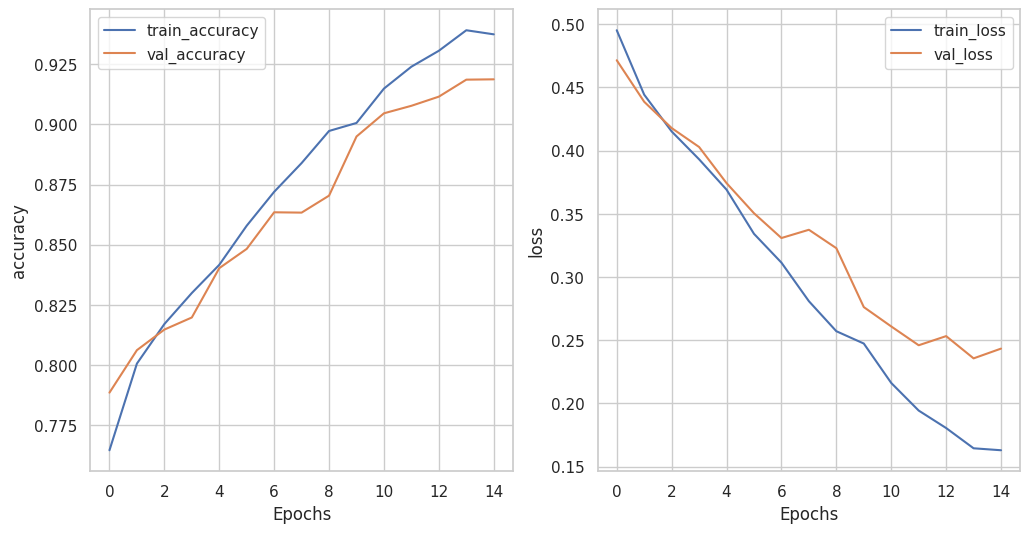

In [ ]:
plot_graphs(history=history,metric='accuracy', loss='loss')

In [ ]:
scores = model.predict(xvalid_pad)
auc = metrics.roc_auc_score(y_test, scores)
print("Auc: %.2f%%" % (auc * 100))

288/288 [==============================] - 6s 19ms/step
Auc: 97.17%


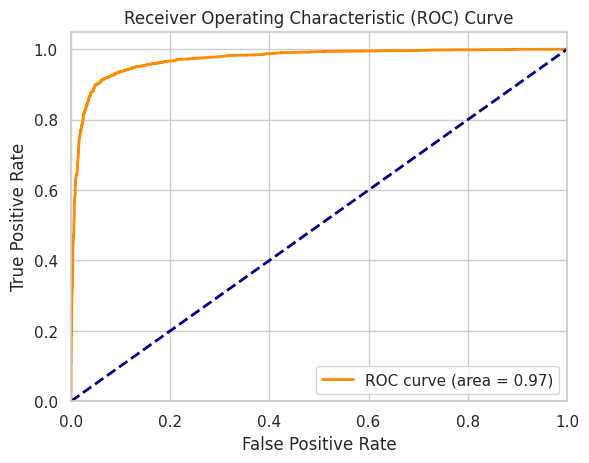

In [ ]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr, tpr, thresholds = roc_curve(y_test, scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()